# Optimizing Customer Engagement in Banking: Predictive Modeling

### Overview

Telephonic marketing remains one of the most effective methods for banks to promote term deposits, although it requires substantial investment in call centers. To optimize outreach efforts, it's essential to identify potential customers likely to convert before initiating calls.

The dataset pertains to direct marketing campaigns (phone calls) conducted by a Portuguese banking institution. The primary objective is to predict whether clients will subscribe to a term deposit.

### Objective

The project aims to explore and conduct comprehensive data analysis on the dataset, followed by building a predictive model using the Random Forest algorithm. Hyperparameter tuning will also be performed to enhance the model's performance.

### Feature Descriptions:

1. **Age**: Numeric variable indicating the client's age.
2. **Job**: Categorical variable specifying the client's occupation.
3. **Marital**: Marital status of the client (married, divorced, single).
4. **Education**: Level of education attained by the client.
5. **Default**: Binary variable indicating whether the client has credit in default.
6. **Balance**: Average yearly balance in euros (numeric).
7. **Housing**: Binary variable indicating whether the client has a housing loan.
8. **Loan**: Binary variable indicating whether the client has a personal loan.
9. **Contact**: Type of contact communication (telephone, cellular, unknown).
10. **Day**: Last contact day of the month (numeric).
11. **Month**: Last contact month of the year.
12. **Duration**: Last contact duration in seconds.
13. **Campaign**: Number of contacts performed during the campaign.
14. **Pdays**: Number of days passed since the client was last contacted from a previous campaign (-1 means not previously contacted).
15. **Previous**: Number of contacts performed before this campaign and for this client.
16. **Poutcome**: Outcome of the previous marketing campaign.
17. **Y**: Target variable indicating whether the client subscribed to a term deposit (binary: "yes", "no").


In [16]:
import warnings
warnings.filterwarnings("ignore")

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn import metrics
from scipy.stats import randint
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
#combining both datasets
df1 = pd.read_csv('/kaggle/input/ipshitasingh/test.csv', sep=';')
df2 = pd.read_csv('/kaggle/input/ipshitasingh/train.csv', sep=';')

In [19]:
bank_data = pd.concat([df1,df2],ignore_index=True)
bank_data.head(4)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no


In [20]:
bank_data.shape

(49732, 17)

In [21]:
#finding null values
bank_data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [22]:
bank_data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,49732.000000,49732.000000,49732.000000,49732.000000,49732.000000,49732.000000,49732.000000
mean,40.957472,1367.761562,15.816315,258.690179,2.766549,40.158630,0.576892
std,10.615008,3041.608766,8.315680,257.743149,3.099075,100.127123,2.254838
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1431.000000,21.000000,320.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [23]:
bank_data.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

## Preprocessing the Data

#### Handling Missing Values

Filling `unknown` values in `'job'` , `'education'`, and `'contact'` with modal values

In [24]:
cols_to_fill = ['job', 'education', 'contact']

for col in cols_to_fill:
    #calculating mode for the current column
    mode_value = bank_data[col].mode().iloc[0]
    
    #replacing 'unknown' with mode value inplace
    bank_data[col].replace('unknown', mode_value, inplace=True)

bank_data.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,cellular,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,cellular,5,may,226,1,-1,0,unknown,no


#### Encoding Categorical Variables

One Hot Encoding for all categorical variables as these have nominal values

Label Encoding for `education` as it has ordinal values

In [25]:
cat_cols = list(bank_data.select_dtypes(include="object").columns)
cat_cols.remove('education')
print(cat_cols)

['job', 'marital', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']


In [26]:
#one hot encoding
bank_data_encoded = pd.get_dummies(bank_data, columns=cat_cols, drop_first=True)


In [27]:
#label encoding
le = LabelEncoder()
bank_data_encoded['education'] = le.fit_transform(bank_data_encoded['education'])

In [28]:
bank_data_encoded.head(5)

,age,education,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,y_yes
0,30,0,1787,19,79,1,-1,0,False,False,...,False,False,False,False,True,False,False,False,True,False
1,33,1,4789,11,220,1,339,4,False,False,...,False,False,True,False,False,False,False,False,False,False
2,35,2,1350,16,185,1,330,1,False,False,...,False,False,False,False,False,False,False,False,False,False
3,30,2,1476,3,199,4,-1,0,False,False,...,True,False,False,False,False,False,False,False,True,False
4,59,1,0,5,226,1,-1,0,True,False,...,False,False,True,False,False,False,False,False,True,False


## Exploratory Data Analysis

#### Distribution of Target Variable 

Proportion of customers who have the subscription

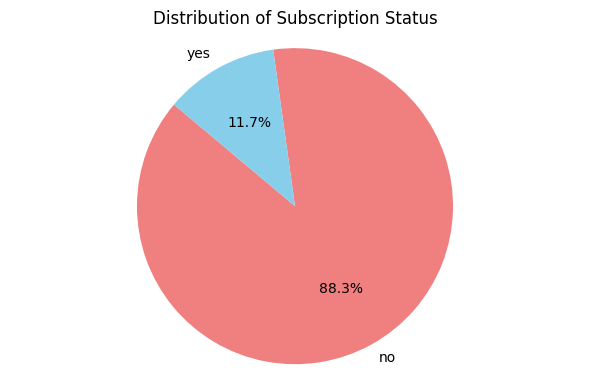

In [29]:
#occurrences of each class
class_counts = bank_data['y'].value_counts()

plt.figure(figsize=(6, 4))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', colors=['lightcoral', 'skyblue'], startangle=140)
plt.title('Distribution of Subscription Status', fontsize=12)
plt.axis('equal') 
plt.tight_layout()
plt.show()

#### Customer Demographics

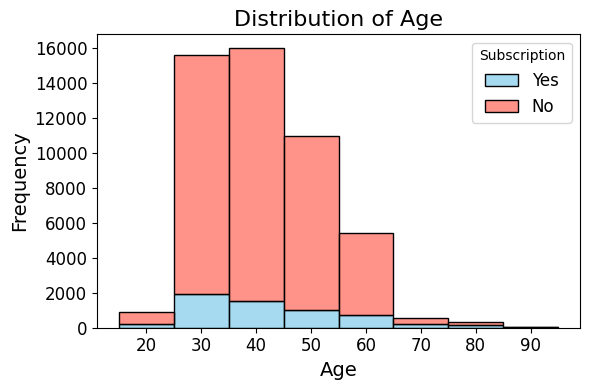

In [30]:
age_bins = range(15, 101, 10)  

plt.figure(figsize=(6, 4))
sns.histplot(data=bank_data, x='age', bins=age_bins, hue='y', multiple='stack', palette=["#FF6F61", "#87CEEB"], edgecolor='black')
plt.title('Distribution of Age', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Subscription',labels=['Yes', 'No'], fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

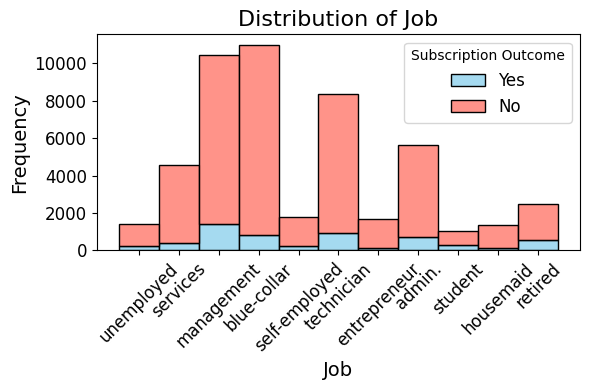

In [31]:
plt.figure(figsize=(6, 4))
ax = sns.histplot(data=bank_data, x='job', hue='y', multiple='stack', palette=["#FF6F61", "#87CEEB"], edgecolor='black')
ax.tick_params(axis='x', rotation=45)

plt.title('Distribution of Job', fontsize=16)
plt.xlabel('Job', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Subscription Outcome', fontsize=12, labels=['Yes', 'No'])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

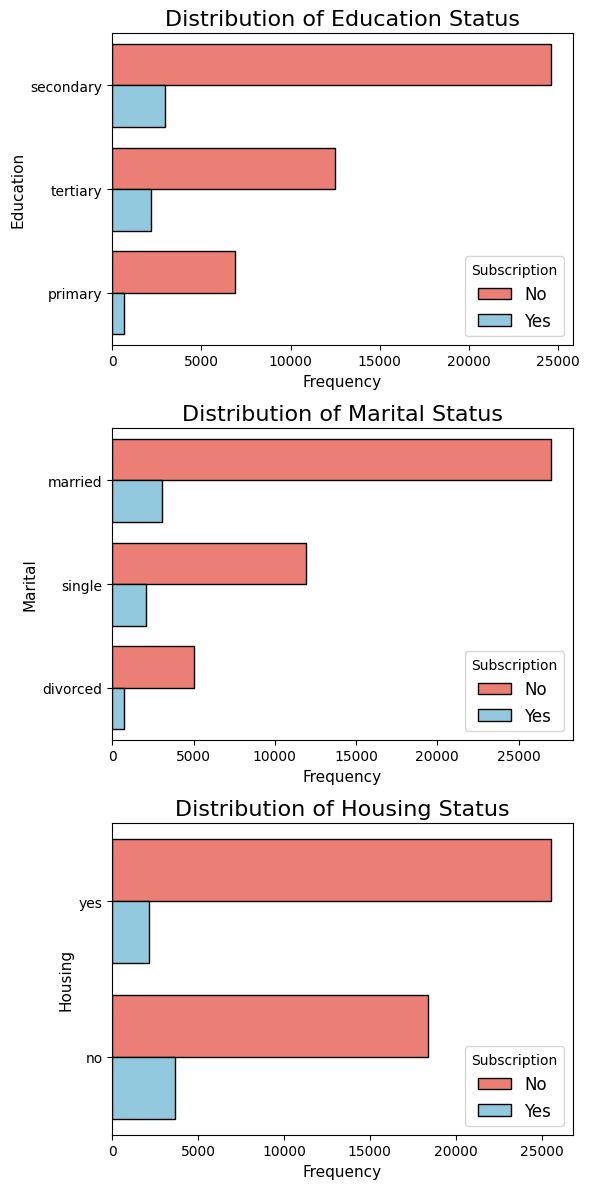

In [32]:
demographic_vars = ['education', 'marital', 'housing']

plt.figure(figsize=(6, 4 * len(demographic_vars)))  

for i, var in enumerate(demographic_vars):
    plt.subplot(len(demographic_vars), 1, i+1)  # Set subplot layout
    # Sorting df based on variable's value counts
    sorted_data = bank_data[var].value_counts().sort_values(ascending=False).index
    sns.countplot(y=var, hue='y', data=bank_data, order=sorted_data, palette=["#FF6F61", "#87CEEB"], edgecolor='black')
    plt.title(f'Distribution of {var.capitalize()} Status', fontsize=16)
    plt.xlabel('Frequency', fontsize=11)
    plt.ylabel(var.capitalize(), fontsize=11)
    plt.legend(title='Subscription', fontsize=12, labels=['No', 'Yes'])
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout() 

plt.show()

#### Comparison of Contact Duration Distribution
Between Subscribed and Not Subscribed Customers

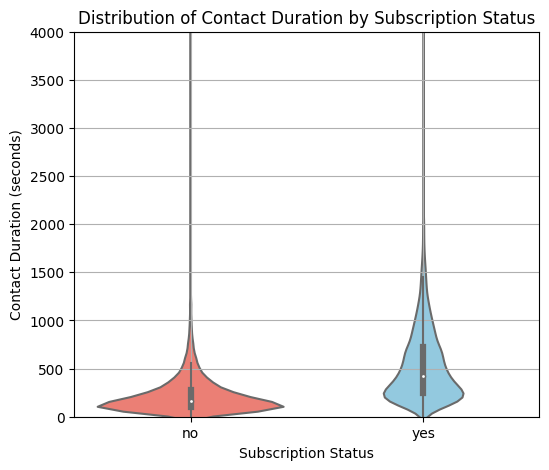

In [33]:
#separating data for subscribed and not subscribed customers
subscribed = bank_data[bank_data['y'] == 'yes']
not_subscribed = bank_data[bank_data['y'] == 'no']

plt.figure(figsize=(6, 5))  

#violin plots for both groups 
sns.violinplot(x='y', y='duration', data=bank_data, palette={'yes': '#87CEEB', 'no': '#FF6F61'})

plt.xlabel('Subscription Status')
plt.ylabel('Contact Duration (seconds)')
plt.title('Distribution of Contact Duration by Subscription Status')
plt.ylim(0, 4000)  

plt.grid(True) 
plt.show()

- The plot depicting `Subscription Status: No` suggests more variability across a broader range in contact durations compared to *subscribed* customers. 
It also implies that, on average, these customers have comparatively shorter contact durations, indicating potentially less engagement with the marketing efforts.

- Conversely,`Subscription Status: Yes` plot indicates a more concentrated distribution of contact durations with fewer extreme values, suggesting a more consistent response pattern among subscribed customers.

## Machine Learning: Random Forest

#### Splitting the Data

In [34]:
#splitting the data into features (X) and target (y)
X = bank_data_encoded.drop('y_yes', axis=1)
y = bank_data_encoded['y_yes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state=42)

#### Handling Imbalanced Features 

Using SMOTE (Synthetic Minority Over-sampling Technique) to oversample the minority class

In [35]:
smote = SMOTE(sampling_strategy='minority', random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

#class distribution before and after oversampling
print("Class distribution before SMOTE:")
print(y_train.value_counts())

print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts())

Class distribution before SMOTE:
y_yes
False    32980
True      4319
Name: count, dtype: int64

Class distribution after SMOTE:
y_yes
False    32980
True     32980
Name: count, dtype: int64


## Training the Model

In [47]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

In [48]:
#predictions on training and testing data
y_train_pred = rf.predict(X_train_smote)
y_test_pred = rf.predict(X_test)

In [49]:
#calculating accuracy on training and testing data
train_accuracy = metrics.accuracy_score(y_train_smote, y_train_pred)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)

## Evaluating the Model
on Training and Testing datasets

In [50]:
#evaluation metrics for train set
train_accuracy = metrics.accuracy_score(y_train_smote, y_train_pred)
train_precision = metrics.precision_score(y_train_smote, y_train_pred)
train_recall = metrics.recall_score(y_train_smote, y_train_pred)

#evaluation metrics for test set
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_precision = metrics.precision_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred)

print("Train Evaluation Metrics:")
print("Accuracy:", round(train_accuracy, 3))
print("Precision:", round(train_precision, 3))
print("Recall:", round(train_recall, 3))
print("\nTest Evaluation Metrics:")
print("Accuracy:", round(test_accuracy, 3))
print("Precision:", round(test_precision, 3))
print("Recall:", round(test_recall, 3))

Train Evaluation Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0

Test Evaluation Metrics:
Accuracy: 0.908
Precision: 0.634
Recall: 0.553


- **Training Metrics**: Perfect scores across accuracy, precision, and recall (1.0) suggest the model fits the training data perfectly, but it suggests overfitting.

- **Testing Metrics**: While accuracy remains high (90%), precision and recall scores drop, indicating the model's limitations in generalizing to new data.

Overall, the model performs exceptionally well on the training set but has room for improvement when applied to unseen data.

## Hyperparameter Tuning

In [57]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

#initiating another random forest classifier
rf = RandomForestClassifier(random_state=42)

In [58]:
#using random search to find best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

#fitting random search object to data
rand_search.fit(X_train_smote, y_train_smote)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b48516f7e20>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b4851736c20>})

In [59]:
#best model
best_rf = rand_search.best_estimator_

#best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 14, 'n_estimators': 360}


In [60]:
#generating predictions with the best model
y_pred = best_rf.predict(X_test)

In [61]:
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)

print("Accuracy after Optimization:", round(accuracy, 3))
print("Precision after Optimization:", round(precision, 3))
print("Recall after Optimization:", round(recall, 3))

Accuracy after Optimization: 0.895
Precision after Optimization: 0.555
Recall after Optimization: 0.633


* After optimization using RandomizedSearchCV, there is a slight decrease in accuracy and precision but a significant increase in recall.
* This suggests that while the optimized model may sacrifice some precision, it demonstrates improved ability to correctly identify positive cases.